In [1]:
import pickle
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from simulator.data_structures import *
from simulator.simulator import Simulator
from strategies.get_pnl import get_pnl_df, visualize_pnl
from strategies.baseline import BaselineStrategy

plt.style.use('ggplot')
sns.set(font_scale=1.5)

In [2]:
# %%time
# ready_md = load_md_from_file("md/btcusdt:Binance:LinearPerpetual")

In [3]:
# %%time

# with open('data/market_data.pickle', 'rb') as f:
#     ready_md = pickle.load(f)

CPU times: user 51.3 s, sys: 1min 13s, total: 2min 4s
Wall time: 2min 53s


# Baseline Strategy: quoting on the best level

## Running Strategy

In [3]:
sim = Simulator("md/btcusdt:Binance:LinearPerpetual", 3, 3, ready_md=ready_md)
baseline_strategy = BaselineStrategy(max_position=1, maker_fee=0, time_to_cancel=50, trade_size=0.001)

In [5]:
%%time

history, completed_trades = baseline_strategy.run(sim)

Current time: 2022-06-23 00:10:02.251570263
Coin Position: -0.5670000000000004
Money Position: 11369.645500000115

Current time: 2022-06-23 00:20:02.270048319
Coin Position: -0.31300000000000006
Money Position: 6218.918400000028

Current time: 2022-06-23 00:30:02.275325530
Coin Position: -0.3650000000000001
Money Position: 7213.44628000038

Current time: 2022-06-23 00:40:02.276875154
Coin Position: 0.8630000000000008
Money Position: -17659.553919999653

Current time: 2022-06-23 00:50:02.282619947
Coin Position: 0.40200000000000036
Money Position: -8312.176319999713

Current time: 2022-06-23 01:00:02.288086
Coin Position: -0.40600000000000025
Money Position: 8158.1175800002675

Current time: 2022-06-23 01:10:02.306757641
Coin Position: -0.127
Money Position: 2465.5410800002805

Current time: 2022-06-23 01:20:02.318069189
Coin Position: 0.5430000000000005
Money Position: -11156.703819999635

Current time: 2022-06-23 01:30:02.330147867
Coin Position: -0.8130000000000005
Money Position: 16

Current time: 2022-06-23 12:10:03.723962410
Coin Position: 0.38000000000000045
Money Position: -8422.00676000166

Current time: 2022-06-23 12:20:03.747740985
Coin Position: -0.4970000000000002
Money Position: 9688.168239998138

Current time: 2022-06-23 12:30:03.753808013
Coin Position: -0.8840000000000006
Money Position: 17680.778539998144

Current time: 2022-06-23 12:40:03.772022140
Coin Position: 0.9290000000000008
Money Position: -20083.997160001716

Current time: 2022-06-23 12:50:03.792865216
Coin Position: 0.9490000000000008
Money Position: -20506.453160001478

Current time: 2022-06-23 13:00:03.817108619
Coin Position: 0.41800000000000037
Money Position: -9610.846760000773

Current time: 2022-06-23 13:10:03.825725965
Coin Position: 0.07600000000000007
Money Position: -2559.2863600007554

Current time: 2022-06-23 13:20:03.832755527
Coin Position: 0.7040000000000006
Money Position: -15488.569660000714

Current time: 2022-06-23 13:30:03.840372791
Coin Position: 0.9450000000000008
Mon

## Results Visualization

In [2]:
# df = get_pnl_df(history)
# df.set_index('time', inplace=True)

# df.to_csv('data/pnl_df.csv')
df = pd.read_csv('data/pnl_df.csv', index_col='time')
df.index = pd.to_datetime(df.index)

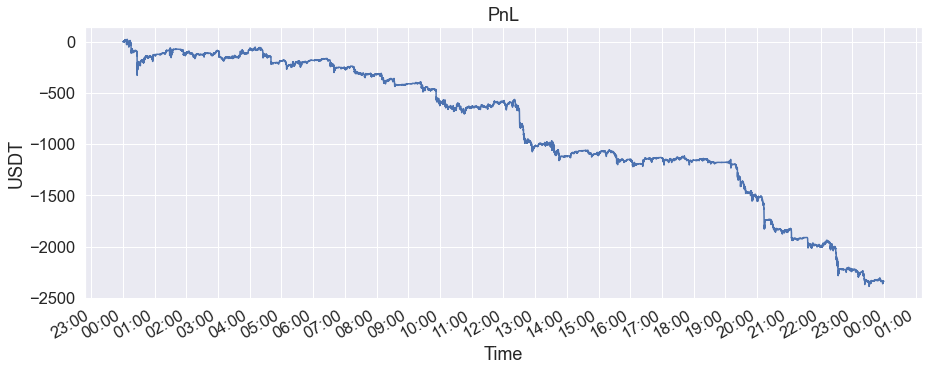

In [5]:
visualize_pnl(df, freq=100)